In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo
from typing import List, Dict
import re
import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [4]:
all_nodes = handler.load_docs()

In [7]:
all_nodes

[TextNode(id_='2489352a-7c62-4272-8a19-0746ceb0f845', embedding=None, metadata={'Header_1': 'Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics', 'experimental_variable_entities': ['channelrhodopsin', 'optogenetics'], 'fig_refs': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c2155598-52f8-4e4f-9b94-62149747c0b0', node_type=None, metadata={}, hash=None)}, text='Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics\n\nClaire N. Bedbrook<sup>1</sup>, Kevin K. Yang<sup>2,†</sup>, J. Elliott Robinson<sup>1,†</sup>, Elisha D. Mackey<sup>1</sup>, Viviana Gradinaru<sup>1,*</sup>, Frances H. Arnold<sup>1,2,*<

In [5]:
fig_num = 3

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [6]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [7]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [8]:
response = query_tool(prompt)

In [9]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [10]:
figure_struct = output_parser.parse(response.content)

In [11]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 3
	Panel: b

		Plot: Microscope images
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Neuron morphology', categorical=False)]
	Panel: c

		Plot: Photocurrent bar graphs
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Light intensity', categorical=True)] dependent_variables=[Variable(name='Photocurrent', categorical=False)]
	Panel: d

		Plot: Spike fidelity vs Light intensity
			independent_variables=[Variable(name='Light intensity', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: e

		Plot: Spike fidelity vs Frequency
			independent_variables=[Variable(name='Frequency', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: f

		Plot: Voltage traces
			independent_variables=[Variable(n

In [12]:
panel = figure_struct.panels[2]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, str] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting categorical labels from plots in scientific papers.
    You will always primarily look to the image of the figure.
    If the information is not available in the image, you can look to the text.
    You will always dummy check your answer by counting the number of expected labels in the image.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
        In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric independent variable and a plot containing datapoints corresponding to that variable.
    Your job is to give the set of values for that variable for the markers in the the specific plot (not the whole figure). 
    You will always dummy check your answer by counting the number of expected datapoints in the plot.

    YOUR CURRENT TASK:

In Figure {fig_num}{panel.name}, plot title/description: {plot.name}, what set are the values of {iv.name} plotted across all data in the panel?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
        THAT IS, DO NOT REPORT THE LOCATIONS OF AXIS TICKE MARKS OR TICK MARK LABELS, REPORT THE VALUES OF THE POINTS ON THE PLOT!!!
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = query_tool(prompt)
    text = response.content

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity' categorical=False
name='ChR variant' categorical=True


In [13]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'ChRger1': 'pink', 'ChRger2': 'blue', 'ChRger3': 'green', 'CoChR': 'gray', 'ChR2': 'black'})]

In [14]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [15]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [16]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given a numeric dedependent variable and a plot containing data points which have values for that variable.
    Your job is to give values for the markers in the plot as a function of the provided independent variables.
    We want to match the data points in the plot EXACTLY - not just the shapes or trends.
    You will always dummy check your answer by counting the number of expected datapoints, lines, etc in the plot.
    When there is a discrepency between text and graphic, align your answer to the graphic.

In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = query_tool(prompt)
panel_df = output_parser.parse(data_response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [17]:
data_response.raw_output.source_nodes

[NodeWithScore(node=ImageNode(id_='ddbd3ffb-d1c1-4a05-9c3a-180685f3910b', embedding=None, metadata={'page_number': 24, 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='79966a73-edea-46f3-b47f-81295e5616cb', node_type=None, metadata={}, hash=None)}, text='The graphic compares the performance of ChRger variants with commonly used ChR2 (H134R) and CoChR in cultured neurons and acute brain slices. It includes data on photocurrent strength, spike fidelity, and light intensity response.\n\na) ChRs were cloned into an AAV vector with either the hSyn or CamKIIa promoter and packaged into rAAV-PHP.eB for expression in culture and in vivo.\n\nb) Cultured neurons expressing ChRgers and ChR2 (H134R) under the hSyn promoter. Images show neurons with ChR2, ChRger1, ChRger2, and ChRger3. Scale bars are 10 μm.\n\nc) Peak and steady-state photocurrent with low-intensity (8x10^-3 mW mm^-2) a

In [18]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
# chr_variant_names = [v for v in chr_variant_iv.values]
chr_variant_colors = [v for k,v in chr_variant_iv.values.items()]

# def get_color(color_name):
#     try:
#         return mcolors.to_rgba(color_name)
#     except ValueError:
#         # If the color name is not recognized, you can provide a fallback
#         return mcolors.to_rgba('gray')
    



In [19]:
import seaborn as sns

[]

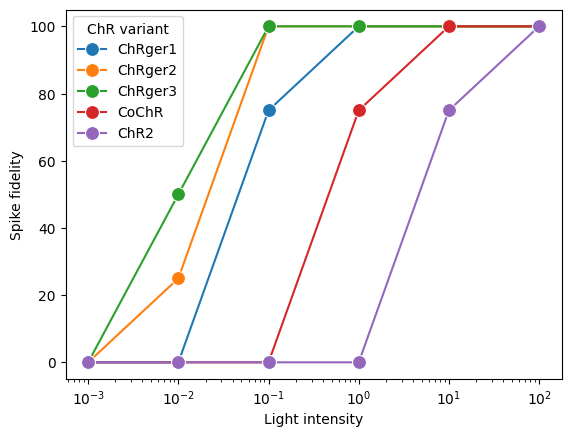

In [20]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [327]:
from PIL import Image

# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img = Image.open('plot.png')

In [328]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO

from plotreader.utils.base import BasicAnthropicLLM

claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")

for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response = claude_mm.message(prompt, images = [source_figure, generated_img])

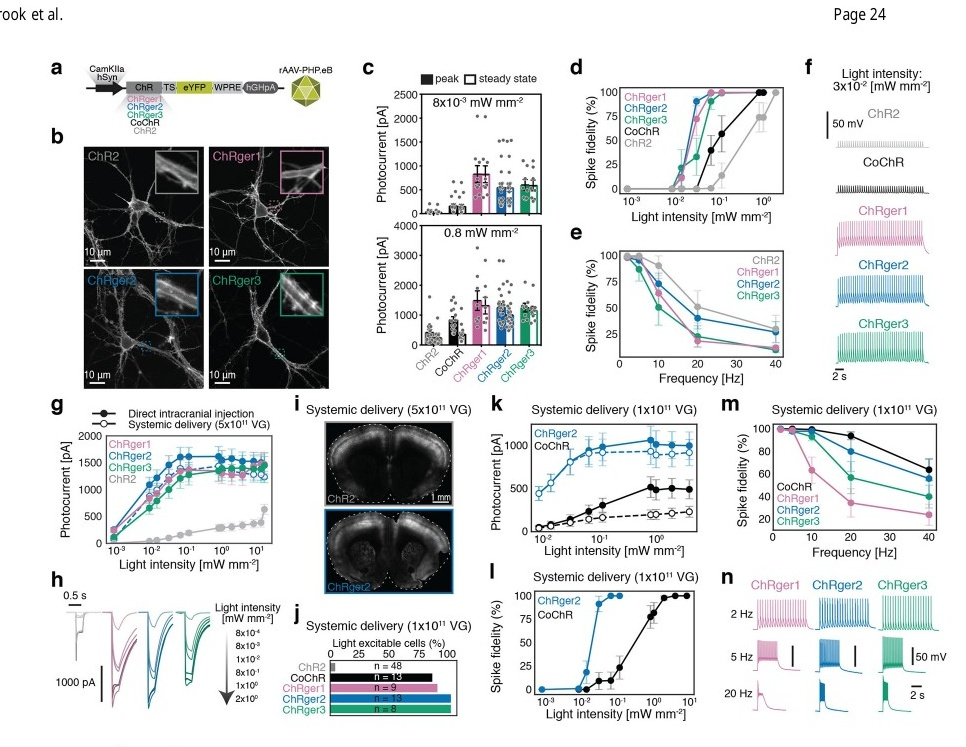

In [329]:
source_figure

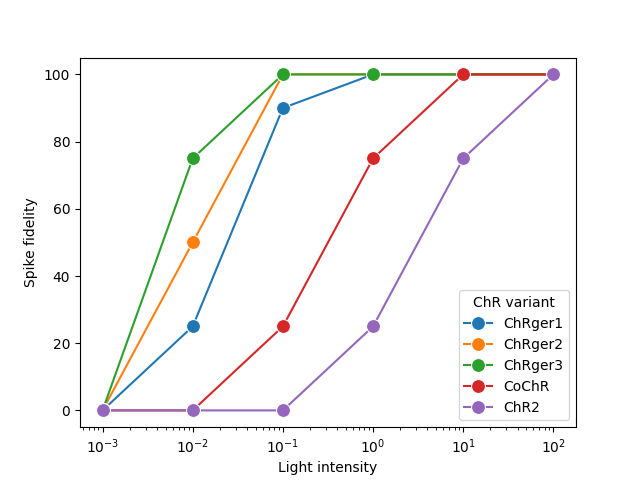

In [330]:
generated_img

In [331]:
print(response.content[0].text)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves appear to be smoother and more sigmoidal, especially between 0.01 and 0.1 mW/mm². In the re-plotted data, these curves are more angular and abrupt. For example, ChRger3 in the re-plot jumps from 75% to 100% spike fidelity between 0.01 and 0.1 mW/mm², while in the original, it appears to have a more gradual increase.

2. CoChR performance at low light intensities: In the source figure, CoChR shows some activity (around 25% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm² and only starts showing activity (25%) at 0.1 mW/mm².

3. ChR2 performance at higher light intensities: In the source figure, ChR2 appears to reach close to 100% spike fidelity at 100 mW/mm². In the re-plotted data, ChR2 reaches exactly 100% at this intensity

In [332]:
feedback = response.content[0].text

In [351]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

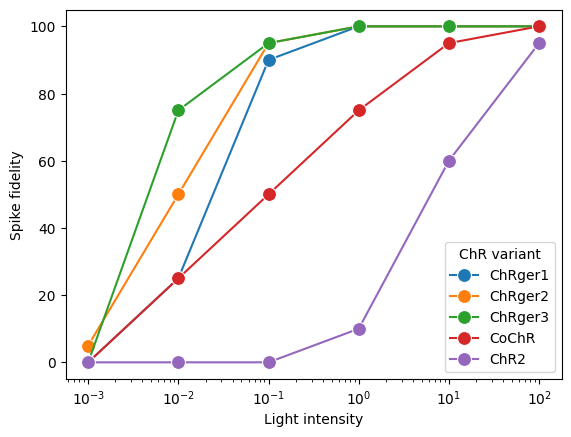

In [352]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [345]:
# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img_rev = Image.open('plot.png')

In [346]:


claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response_2 = claude_mm.message(prompt, images = [source_figure, generated_img_rev])

In [347]:
feedback_2 = response_2.content[0].text
print(feedback_2)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1: In the source figure, the ChRger1 curve (pink) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW/mm². However, in the re-plotted data, there's a sharp jump from 25% at 0.01 mW/mm² to 95% at 0.1 mW/mm². This difference significantly alters the shape of the curve for ChRger1 in the low light intensity range.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 20-30% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm². This difference affects the interpretation of CoChR's sensitivity at low light intensities.

3. ChR2 curve shift: In the source figure, the ChR2 curve (gray) begins to rise noticeably around 1 mW/mm² and reaches about 50% spike fidelity at 10 mW/mm². In the re-plotted data, the ChR2 curv

In [364]:
panel_df

Light intensity ChR variant Spike fidelity
0             0.001     ChRger1              0
1             0.010     ChRger1              0
2             0.100     ChRger1             75
3             1.000     ChRger1            100
4            10.000     ChRger1            100
5           100.000     ChRger1            100
6             0.001     ChRger2              0
7             0.010     ChRger2             25
8             0.100     ChRger2            100
9             1.000     ChRger2            100
10           10.000     ChRger2            100
11          100.000     ChRger2            100
12            0.001     ChRger3              0
13            0.010     ChRger3             50
14            0.100     ChRger3            100
15            1.000     ChRger3            100
16           10.000     ChRger3            100
17          100.000     ChRger3            100
18            0.001       CoChR              0
19            0.010       CoChR              0
20            0.100       CoChR              0
21            1.000       CoChR             50
22           10.000       CoChR            100
23          100.000       CoChR            100
24            0.001        ChR2              0
25            0.010        ChR2              0
26            0.100        ChR2              0
27            1.000        ChR2              0
28           10.000        ChR2             75
29          100.000        ChR2            100

In [348]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback_2,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

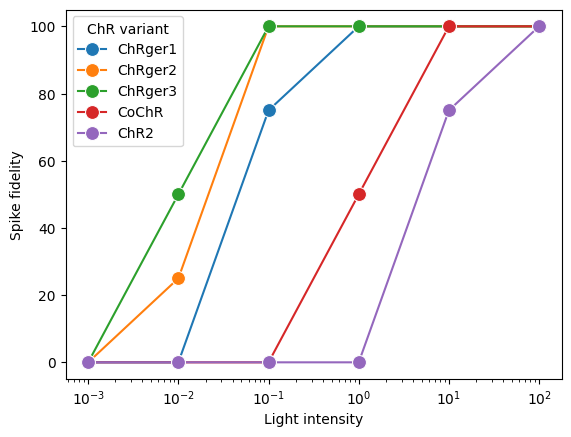

In [28]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [24]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO
from PIL import Image


In [25]:
for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

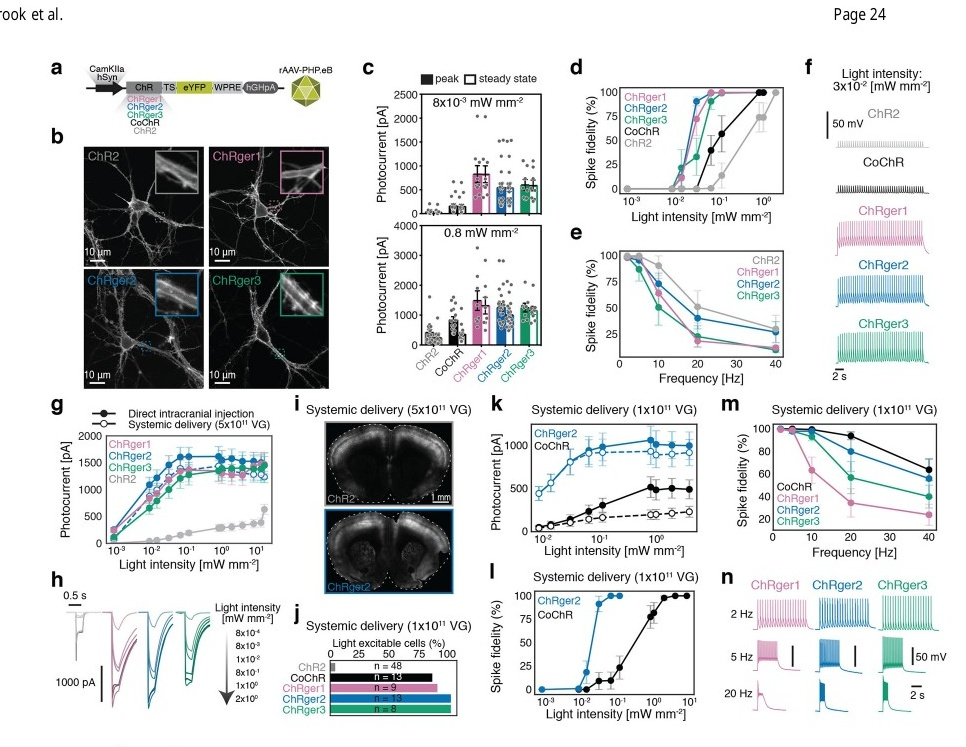

In [26]:
source_figure

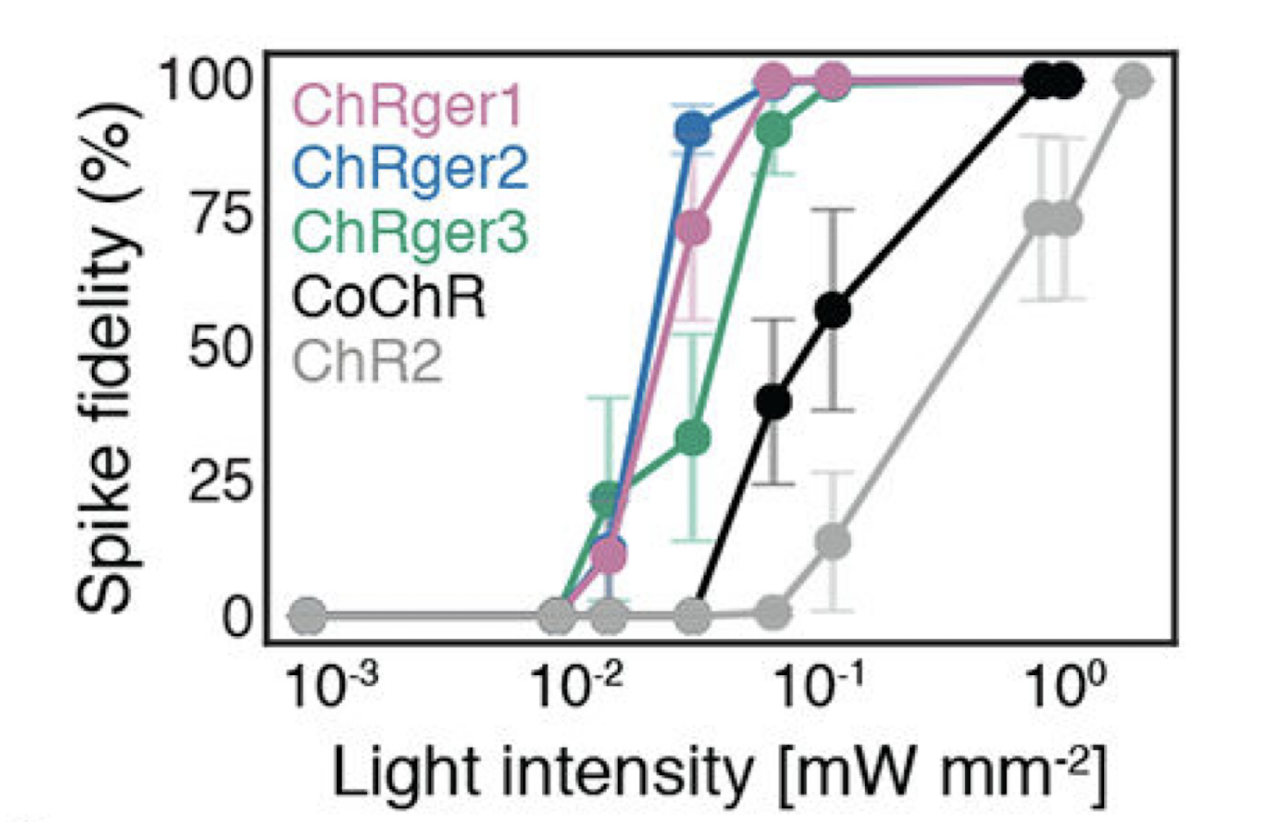

In [27]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
source_image = Image.open(source_panel)
source_image

Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the Light intensity range: The x-axis in the original figure ranges from 10^-3 to 10^0 mW mm^-2, while the recreated plot extends to 10^2. Remove the data points for Light intensity = 100 for all ChR variants.

2. Modify the relative ordering of ChRger variants: In the original figure, ChRger2 appears to be the most sensitive (leftmost curve), followed by ChRger3 and ChRger1. Adjust the Spike fidelity values for these variants to reflect this order.

3. Adjust the CoChR curve: The CoChR curve in the original figure starts increasing later than in the recreated plot. Decrease the Spike fidelity values for CoChR at lower Light intensities (e.g., at 0.1 and 1).

4. Refine the ChR2 curve: The ChR2 curve in the original figure shows a more gradual increase compared to the recreated plot. Add intermediate data points for ChR2 between Light intensities of 1 and 10

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match, listed in order of priority:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be the leftmost (most sensitive), followed closely by ChRger3, then ChRger1. Currently, ChRger3 appears more sensitive than ChRger2 in the recreated plot.

2. Scale the Light intensity axis: The x-axis in the original figure ranges from 10^-3 to 10^0 mW mm^-2. The recreated plot seems to extend to 10^1. Adjust the Light intensity values by dividing them by 10 to match the original scale.

3. Add more data points for ChR2: The original figure shows more points for ChR2, especially in the higher light intensity range. Add more rows for ChR2 with Light intensity values between 1 and 10 (after scaling) to better represent its curve.

4. Adjust the Spike fidelity values for ChRger3: The curve for ChRger3 should be slightly to the right of ChRger2 and have a steeper slope. Decre

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be the leftmost curve, followed by ChRger1, then ChRger3. Update the Spike fidelity values for these variants to reflect their correct order of sensitivity.

2. Extend the Light intensity range: Add data points for light intensities between 1 and 10 mW mm^-2 for all variants. This will capture the full range shown in the original figure.

3. Increase the number of data points for all variants: Add more intermediate light intensity values, especially between 0.01 and 0.1 mW mm^-2, to better capture the shape of the curves.

4. Adjust the Spike fidelity values for CoChR: Shift the CoChR curve to the right by decreasing its Spike fidelity values at lower light intensities. It should start rising later than the ChRger variants.

5. Refine the ChR2 curve: Add more data points for ChR2 between 0.1 and 1 mW 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be shifted slightly to the left (lower light intensities) compared to ChRger1 and ChRger3. This will fix the relative ordering of these variants in the low light intensity range.

2. Extend the range of light intensities: Add data points for lower light intensities (e.g., 10^-4 mW mm^-2) for all variants. This will better match the x-axis range in the original figure.

3. Increase the number of data points: Add more data points between existing light intensity values, especially in the steep rising portions of each curve. This will create smoother curves that better match the original figure.

4. Adjust the spike fidelity values for ChR2: Lower the spike fidelity values for ChR2 across all light intensities. The maximum spike fidelity for ChR2 should be around 75-80% at the highest light intensity, no

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger3: The extracted data shows ChRger1 reaching higher spike fidelity values at lower light intensities than ChRger3, but the original figure shows the opposite. Swap the spike fidelity values for these two variants to correct the relative ordering.

2. Shift the light intensity range for CoChR: The extracted data for CoChR starts showing non-zero spike fidelity at too low light intensities. Increase all light intensity values for CoChR by a factor of 10 to better match the original figure.

3. Extend the light intensity range for ChR2: Add more data points for ChR2 at higher light intensities (e.g., 30 mW mm^-2) to capture the full curve shown in the original figure.

4. Adjust the spike fidelity values for ChRger2: The extracted data shows ChRger2 reaching 100% spike fidelity too quickly. Reduce the spike fidelity v

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be the leftmost curve, followed closely by ChRger3, then ChRger1. Currently, ChRger1 is incorrectly positioned.

2. Scale the Light intensity axis: The x-axis in the original figure ranges from 10^-3 to 10^0 mW mm^-2. Adjust the Light intensity values by multiplying them by 10 to shift the entire range one order of magnitude to the right.

3. Add more data points for CoChR and ChR2: These variants have fewer data points than the ChRger variants. Add intermediate points to smooth out their curves, particularly in the 0.01 to 1 mW mm^-2 range.

4. Adjust the Spike fidelity values for ChR2: The maximum Spike fidelity for ChR2 should be around 75-80%, not 90%. Reduce the Spike fidelity values for ChR2 across the board, particularly at higher light intensities.

5. Refine the curve shapes: The curves in the original fi

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be the leftmost (most sensitive), followed by ChRger1, then ChRger3. Currently, ChRger3 is more sensitive than ChRger1 in the recreated plot.

2. Extend the Light intensity range: Add data points for lower light intensities (down to 10^-3 mW mm^-2) for all variants, and higher intensities (up to 10^0 mW mm^-2) for CoChR and ChR2. This will match the x-axis range in the original figure.

3. Increase the number of data points: Add more data points for each variant to create smoother curves, especially in the transition regions where Spike fidelity increases from 0% to 100%.

4. Adjust the sensitivity of CoChR and ChR2: Shift their curves to the right (higher light intensities) to match their position relative to the ChRger variants in the original figure.

5. Modify the Spike fidelity values for all var

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be the leftmost curve, followed closely by ChRger1, then ChRger3. Currently, ChRger1 and ChRger3 are switched in their relative positions.

2. Extend the x-axis range for Light intensity: The original plot shows data points up to 10^0 mW mm^-2, but the recreated plot extends to 10^1. Remove the data points at 10^1 for CoChR and ChR2.

3. Adjust the Spike fidelity values for ChRger variants at low Light intensities: The curves for ChRger1, ChRger2, and ChRger3 should start rising earlier. Increase the Spike fidelity values for these variants at lower Light intensities (around 10^-2 and below).

4. Modify the CoChR curve: The CoChR curve should rise more gradually and reach 100% Spike fidelity at a higher Light intensity. Adjust the Spike fidelity values for CoChR to create a more gradual increase, with

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be the leftmost curve, followed closely by ChRger1, then ChRger3. Currently, ChRger1 and ChRger3 are switched in their relative positions.

2. Extend the Light intensity range: Add data points for higher Light intensity values (up to 10 mW mm^-2) for all variants except ChR2. This will better match the x-axis range in the original figure.

3. Adjust the Spike fidelity values for CoChR: The CoChR curve should rise more gradually and reach 100% at a higher Light intensity. Decrease the Spike fidelity values for lower Light intensities and add more data points to create a smoother curve.

4. Modify ChR2 data: Add more data points for ChR2 at lower Light intensities (e.g., 0.001, 0.003) with 0% Spike fidelity. Also, extend the curve to higher Light intensities (up to 10 mW mm^-2) with higher Spike fidelit

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger3: ChRger1 should show higher spike fidelity than ChRger3 at lower light intensities. Increase the spike fidelity values for ChRger1 at lower light intensities (e.g., 0.01 and 0.03 mW mm^-2).

2. Extend the range of Light intensity: Add data points for lower light intensities, down to 10^-4 mW mm^-2. This will better match the x-axis range in the original figure.

3. Increase the number of data points: Add more data points between existing light intensity values to create smoother curves, especially for the transitional regions where spike fidelity increases from 0 to 100%.

4. Adjust the CoChR curve: Shift the CoChR curve to the right by decreasing spike fidelity values at lower light intensities and increasing them at higher intensities. This will better match the position of the CoChR curve relative to the other

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2: ChRger2 should be slightly more sensitive (shifted to the left) compared to ChRger1. This fixes the relative ordering of quantities in the plot.

2. Extend the range of Light intensity: Add data points for lower light intensities, particularly for ChRger1, ChRger2, and ChRger3. The original plot shows data points starting from 10^-3 mW mm^-2, while the recreated plot starts at 10^-4. This change affects the range of the data.

3. Increase the number of data points: Add more data points between existing light intensity values to create smoother curves, especially for the transition regions where spike fidelity increases from 0% to 100%. This change affects the number of rows of data.

4. Adjust the spike fidelity values for CoChR: The recreated plot shows CoChR reaching 100% spike fidelity at a lower light intens

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: ChRger2 should be the leftmost curve, followed closely by ChRger1, then ChRger3. Currently, ChRger1 is to the right of ChRger2, which needs to be corrected.

2. Extend the range of Light intensity: The x-axis in the original figure goes up to 10^0 (1 mW mm^-2), while our data goes up to 10^1. Remove the highest Light intensity value (10) for all variants to match the original scale.

3. Add more data points for ChR2: The ChR2 curve in the original figure has more points and extends further to the right. Add more data points for ChR2 between 0.1 and 1 Light intensity to better represent its curve.

4. Adjust the Spike fidelity values for CoChR: The CoChR curve in the original figure reaches 100% at a lower Light intensity than in our data. Shift the Spike fidelity values for CoChR to reach 100% at a lower Light inten

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: The extracted data shows ChRger2 as more sensitive than ChRger1, but the original figure shows ChRger1 slightly more sensitive than ChRger2. Swap the data for these two variants to correct the ordering.

2. Extend the range of Light intensity values: The original figure shows data points extending below 10^-3 mW mm^-2. Add more data points for lower Light intensity values (e.g., 10^-4, 10^-5 mW mm^-2) for all variants to match the x-axis range of the original figure.

3. Increase the number of data points for each variant: The extracted data has fewer points per curve compared to the original figure. Add more intermediate Light intensity values and corresponding Spike fidelity values for each ChR variant to create smoother curves.

4. Adjust the Spike fidelity values for ChR2: The extracted data shows ChR2 reaching 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2: The curves for ChRger1 and ChRger2 should be closer together, with ChRger2 slightly to the left of ChRger1. Currently, they appear to overlap too much.

2. Shift the CoChR curve to the right: The CoChR curve should start increasing at higher light intensities, around 0.1 mW mm^-2 instead of 0.05 mW mm^-2.

3. Extend the range of light intensities: Add more data points for higher light intensities, up to 10 mW mm^-2 (10^1 on the log scale), especially for ChR2 and CoChR variants.

4. Adjust the ChR2 curve: The ChR2 curve should have a more gradual increase, starting from around 0.1 mW mm^-2 and reaching only about 75% spike fidelity at the highest light intensity.

5. Smooth out the curves: Add more data points for each variant to create smoother curves, especially in the transition regions where spike fidelity i

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2: The extracted data shows ChRger2 activating at slightly lower light intensities than ChRger1, but the original figure shows the opposite. Swap the light intensity values for these two variants to correct the order.

2. Shift the light intensity range: The x-axis in the original figure ranges from 10^-3 to 10^0, while the extracted data goes from 10^-5 to 10^1. Multiply all light intensity values by 100 to align the range with the original figure.

3. Adjust the CoChR curve: The CoChR curve in the original figure starts increasing later and rises more steeply than in the recreated plot. Increase the light intensity values for CoChR by a factor of 10 to shift the curve to the right, and adjust the intermediate spike fidelity values to create a steeper rise.

4. Modify the ChR2 curve: The ChR2 curve in the original

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the Light intensity range for ChRger1 and ChRger2: The curves for these variants start rising at lower light intensities in the original figure. Shift their data points to lower light intensity values, approximately by a factor of 10 (e.g., 0.001 becomes 0.0001).

2. Extend the Light intensity range for CoChR and ChR2: Add more data points at higher light intensities for these variants, up to 1 mW mm^-2, to match the full range shown in the original figure.

3. Adjust the Spike fidelity values for ChR2: The ChR2 curve in the original figure doesn't reach 100% spike fidelity. Modify the maximum spike fidelity for ChR2 to be around 75-80% at the highest light intensity.

4. Increase the number of data points for all variants: Add more intermediate points for each curve to create smoother transitions and better match the continuous curves in the original figur

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the Light intensity range for all variants: The x-axis in the original figure spans from 10^-3 to 10^0 mW mm^-2. Multiply all Light intensity values by 10 to shift the range from 10^-4 - 10^1 to 10^-3 - 10^0.

2. Extend the Light intensity range for ChRger1 and ChRger2: Add more data points at lower Light intensities (e.g., 10^-3 mW mm^-2) to match the original figure's leftward extension of these curves.

3. Adjust the Spike fidelity values for ChR2: The ChR2 curve in the original figure doesn't reach 100% Spike fidelity. Modify the highest Spike fidelity value for ChR2 to be around 75-80% instead of 100%.

4. Increase the number of data points for all variants: Add more intermediate points to smooth out the curves, especially for ChRger3, CoChR, and ChR2, to better match the gradual increase shown in the original figure.

5. Adjust the relative positions 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the Light intensity range: The x-axis in the original figure spans from 10^-3 to 10^0 mW mm^-2. Multiply all Light intensity values by 10 to shift the range to match the original figure.

2. Modify the relative ordering of ChRger3 and CoChR: The curves for ChRger3 and CoChR should be closer together, with ChRger3 slightly to the left of CoChR. Adjust the Light intensity values for these two variants to achieve this ordering.

3. Extend the range for ChR2: Add more data points for ChR2 at higher Light intensity values (up to 10^0 mW mm^-2 after applying change #1) to complete its curve.

4. Adjust the steepness of curves: The curves in the original figure appear steeper, especially for ChRger1 and ChRger2. Modify the Spike fidelity values to create sharper transitions between 0% and 100%.

5. Add more data points: Increase the number of data points for each 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChR variants: The extracted data shows ChRger1 and ChRger2 as more sensitive than ChRger3, but the original figure shows ChRger3 in between ChRger1 and ChRger2. Reorder the data to match this sequence.

2. Extend the range of Light intensity values: The original figure shows data points extending below 10^-3 mW mm^-2. Add more data points for lower Light intensity values, especially for ChR2 and CoChR.

3. Increase the number of data points for each ChR variant: The original figure shows smoother curves with more data points. Add intermediate Light intensity values for each variant to create smoother curves.

4. Adjust the Spike fidelity values for ChRger1 and ChRger2: The original figure shows these variants reaching 100% Spike fidelity at lower Light intensity values. Shift the 100% Spike fidelity point to lower Light intensity va

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2: The extracted data shows ChRger1 and ChRger2 having identical values, but in the original figure, ChRger2 is slightly to the left of ChRger1. Shift the Light intensity values for ChRger2 to be slightly lower than those of ChRger1.

2. Scale the Light intensity values: The x-axis in the original figure ranges from 10^-3 to 10^0, while the extracted data includes values as low as 10^-4. Multiply all Light intensity values by 10 to align with the original scale.

3. Add more data points for ChR2: The original figure shows a more gradual curve for ChR2, especially in the middle range. Add more rows of data for ChR2 between 0.1 and 1 Light intensity to create a smoother curve.

4. Adjust the Spike fidelity values for CoChR: The extracted data shows CoChR reaching 100% Spike fidelity at 0.05 Light intensity, but the o

KeyboardInterrupt: 

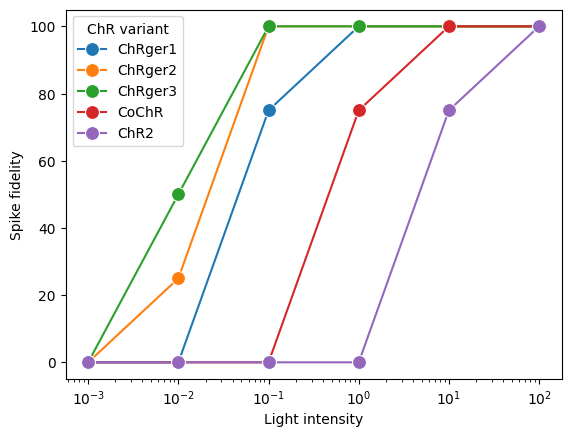

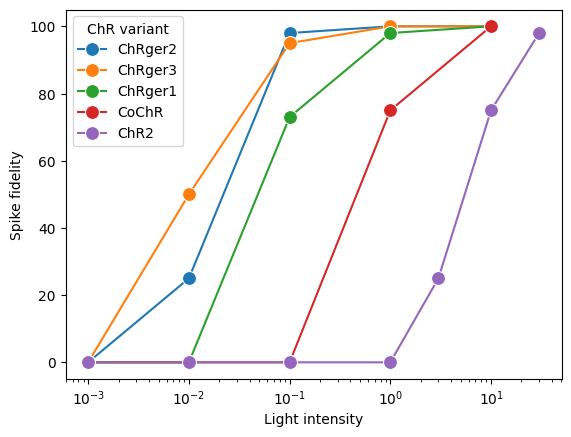

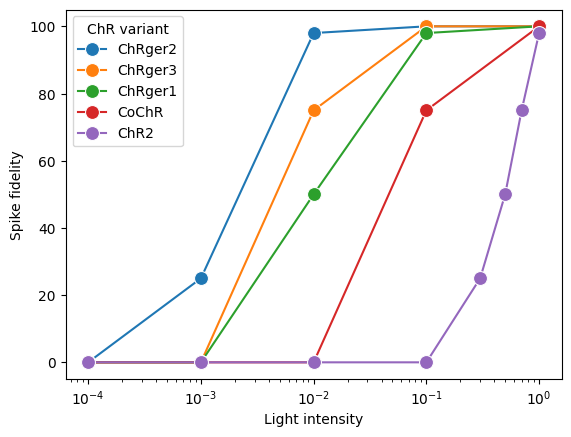

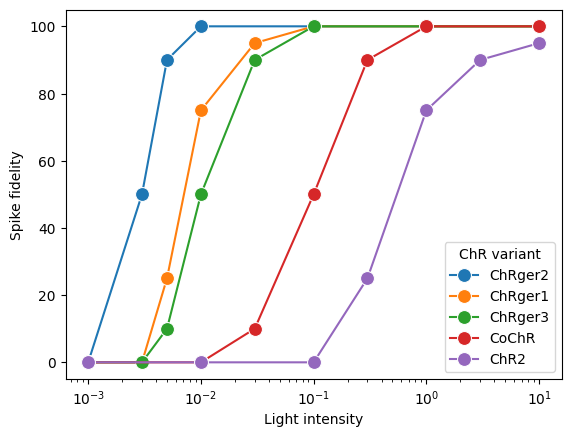

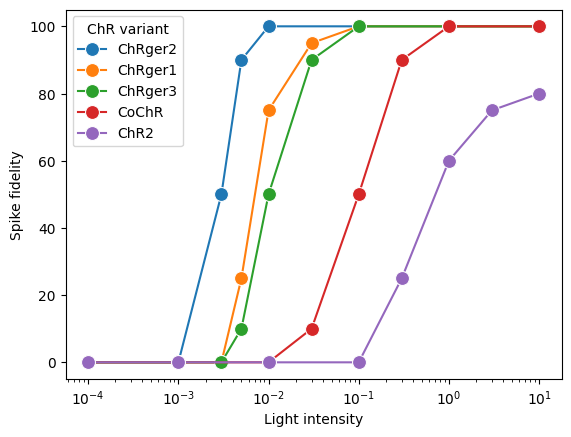

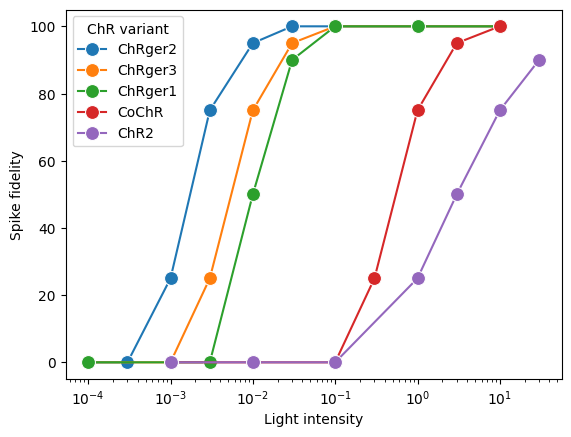

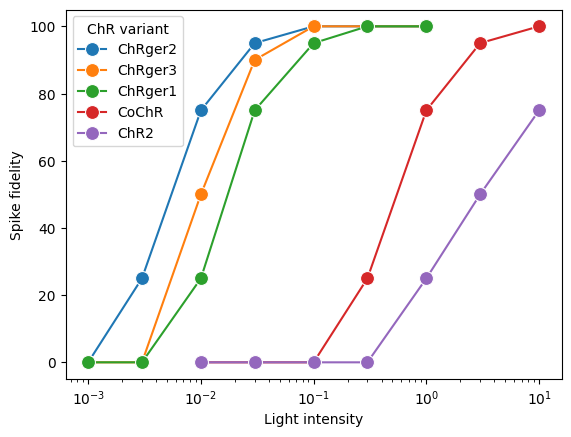

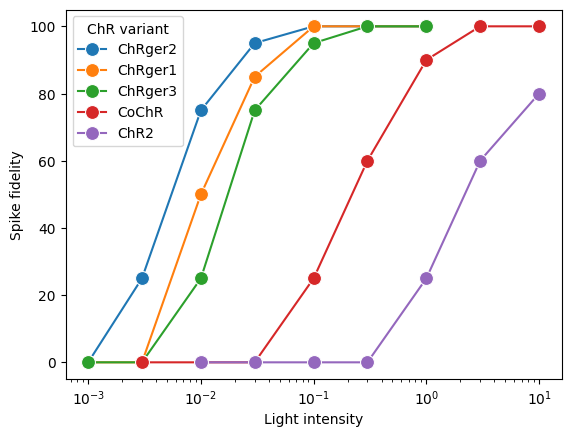

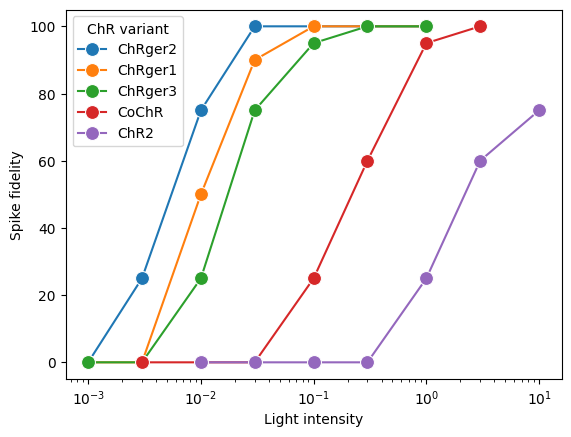

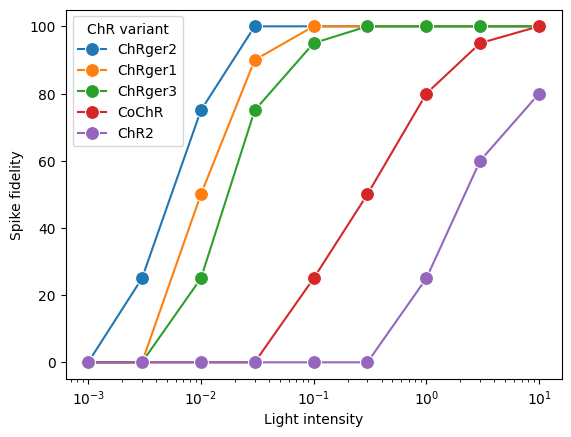

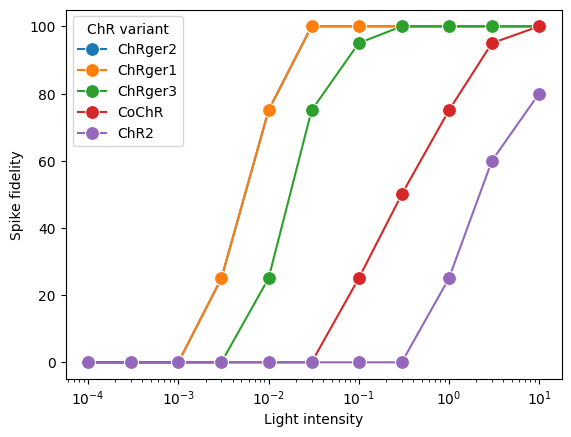

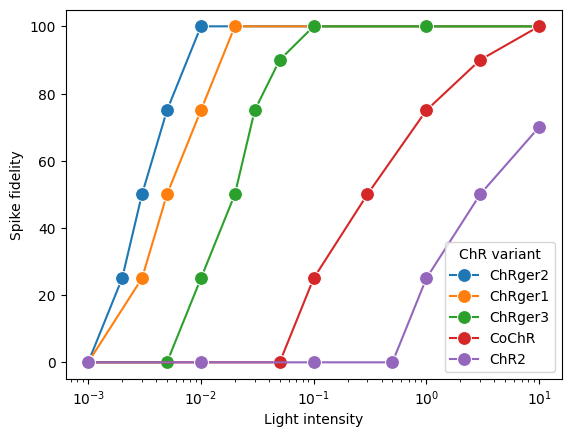

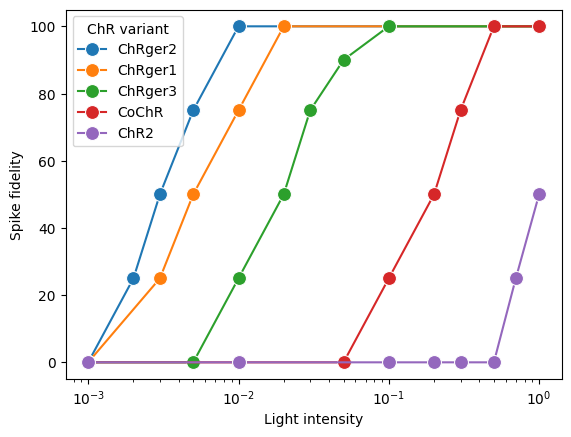

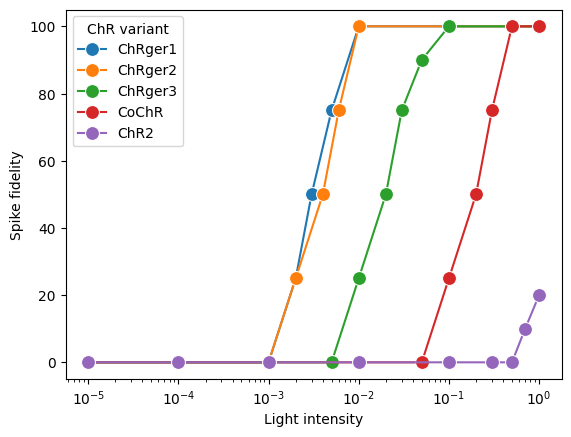

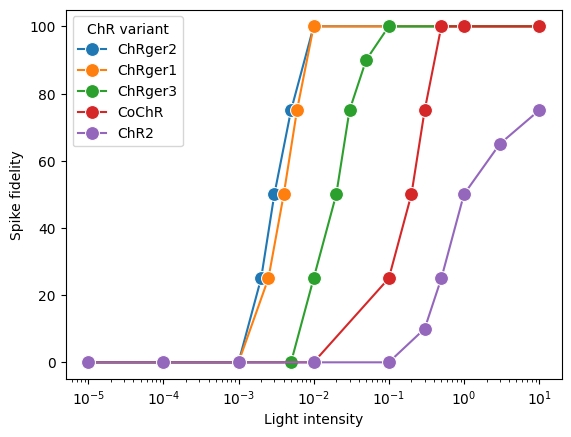

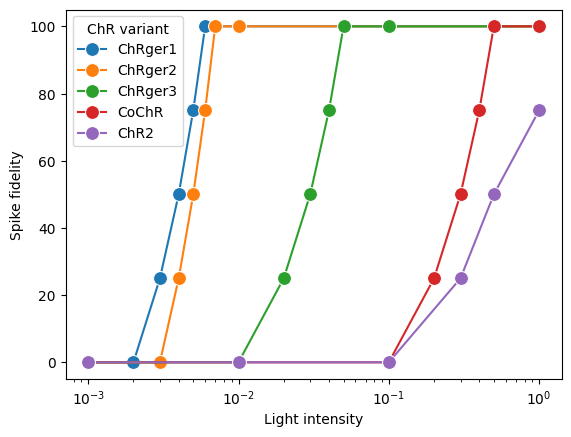

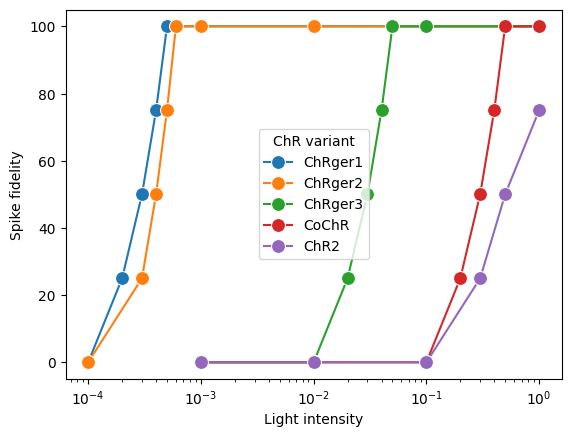

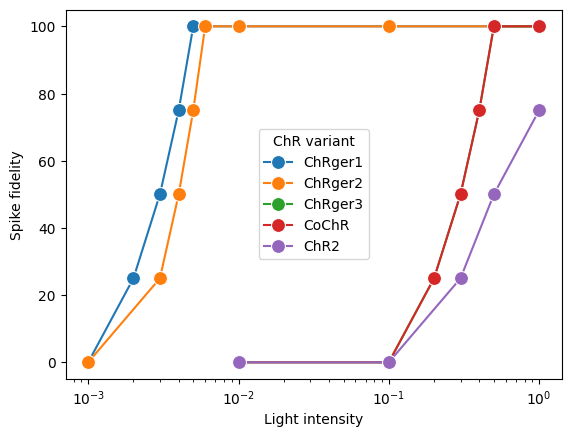

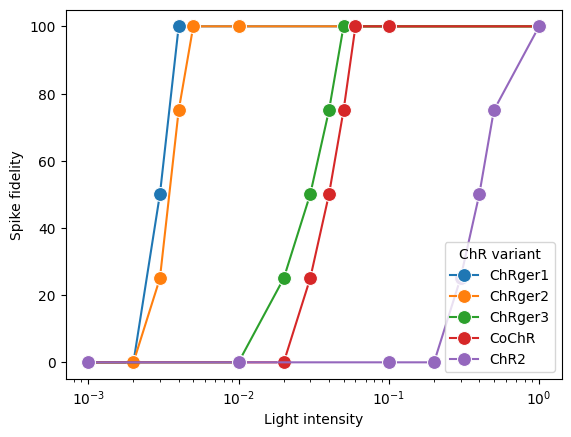

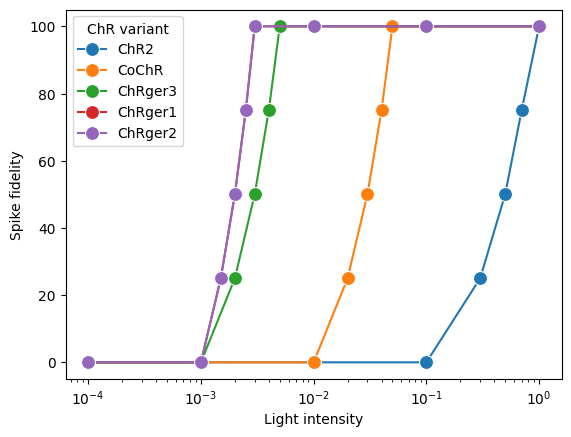

In [33]:
from matplotlib import pyplot as plt
from PIL import Image

fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    ax=axes
)
axes.semilogx()

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

for iter in range(20):




    claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


    prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
Given the full source figure and a recreation of the target plot from the extracted data, list five changes to make to the extracted data to improve the match.
As much as possible, suggest changes that are more general than adjusting individual values.
You can refer to specific variable names, but do not reference colors!

Suggest changes according to the following priority:
1. changes that fix the relative ordering of quantities in the plot
1. changes to the range of the data (e.g. min and max values for a variable)
2. changes to the number of rows of data (e.g. missing values for independent variables)
3. changes that affect the values of many rows at a time

Extracted data used to generate recreated plot:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm.message(prompt, images = [source_image, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
We are extracting a dataframe containing the values of the data points in Figure {fig_num}{panel_name}, plot {plot_name}.
To validate that extraction, we have replotted the points and analyzed the differences. Can you help us use this analysis to improve the extracted dataframe?

Here is you the previous extracted data:
{df_table}

Here are changes based on comparing the extracted data to the source figure:
{feedback}

Please revise the dataframe by making these changes.
And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.


Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
    ).replace("{","<").replace("}",">")

    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = query_tool(prompt)
    panel_df_loop = output_parser.parse(data_response_loop.content).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity',
        y='Spike fidelity',
        hue='ChR variant',
        marker='o',
        # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
        markersize=10,
        ax=axes
    )
    axes.set_xscale('log')  # Set x-axis to logarithmic scale

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

In [401]:
print(prompt)


    YOUR OVERALL JOB:
        You were previously given the following task:

            In Figure 2d, plot Spike fidelity vs Light intensity, what are the values for the dependent variable Spike fidelity?
            And you were asked to return you data in a DataFrame and were provided with information about the independent variables and their values for this plot.

        Here is you the dataframe output from your previous response:
        |    |   Light intensity | ChR variant   |   Spike fidelity |
|---:|------------------:|:--------------|-----------------:|
|  0 |             0.001 | ChRger1       |                0 |
|  1 |             0.003 | ChRger1       |                0 |
|  2 |             0.01  | ChRger1       |               10 |
|  3 |             0.03  | ChRger1       |               40 |
|  4 |             0.06  | ChRger1       |               80 |
|  5 |             0.1   | ChRger1       |               95 |
|  6 |             0.3   | ChRger1       |            

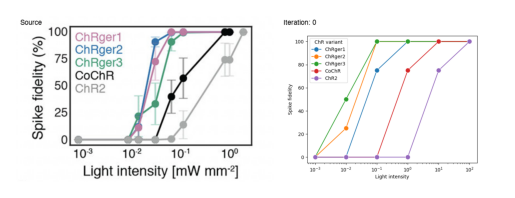

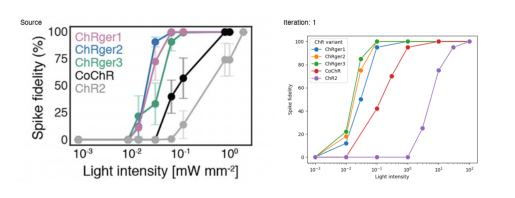

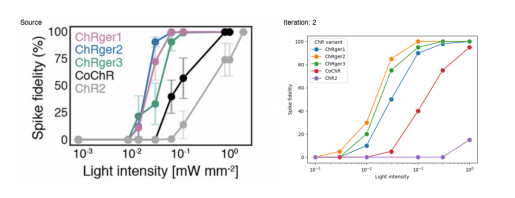

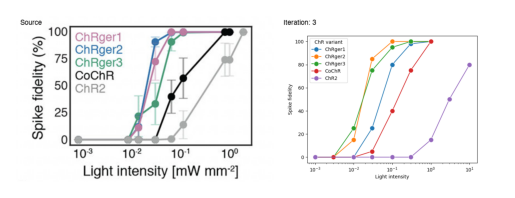

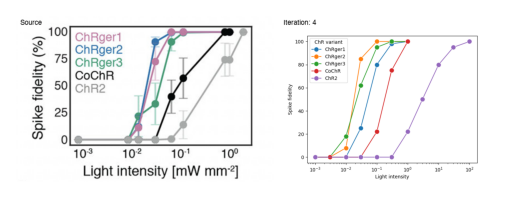

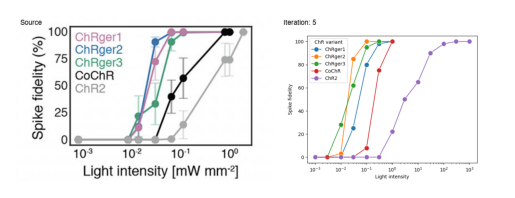

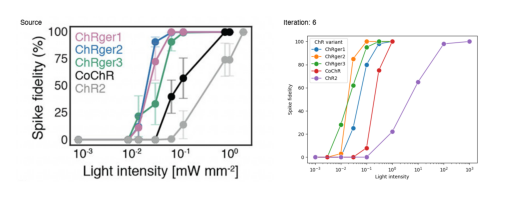

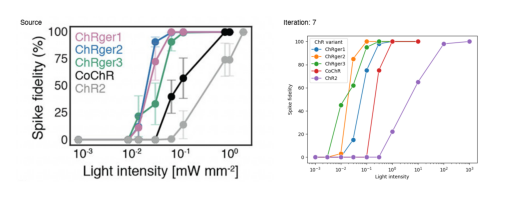

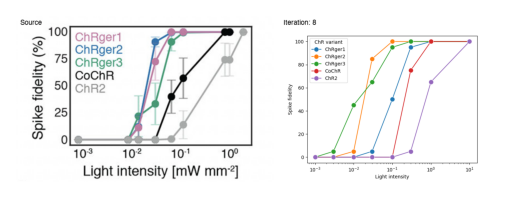

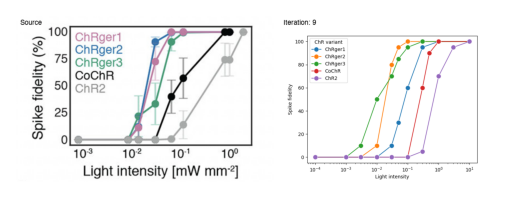

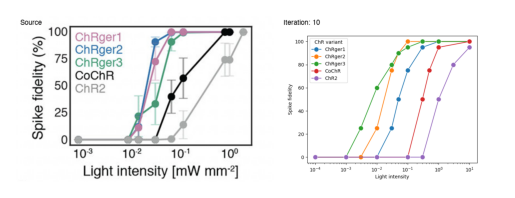

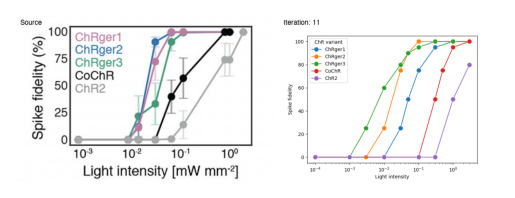

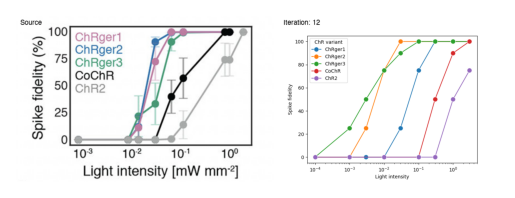

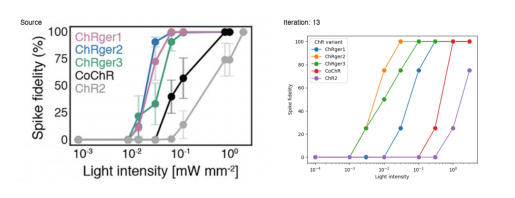

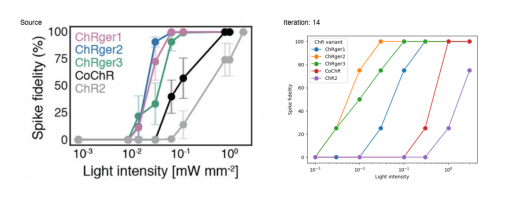

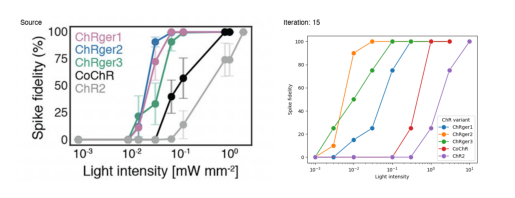

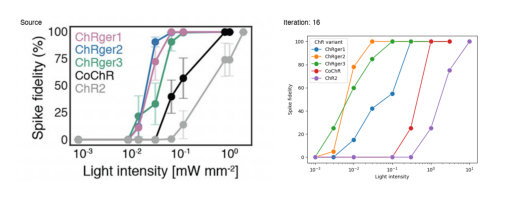

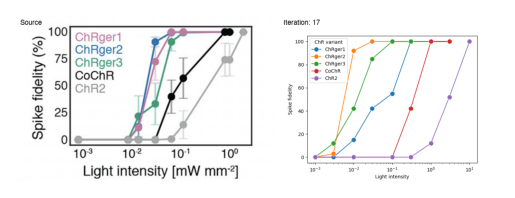

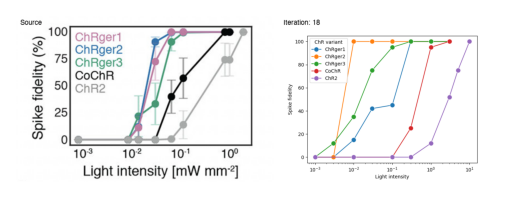

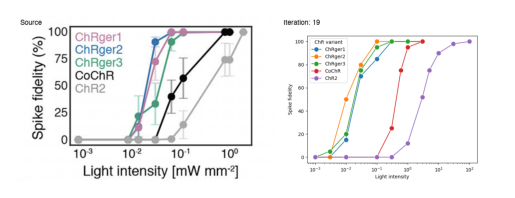

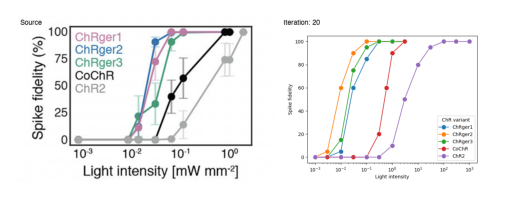

MP4 video saved as 'comparison.mp4'


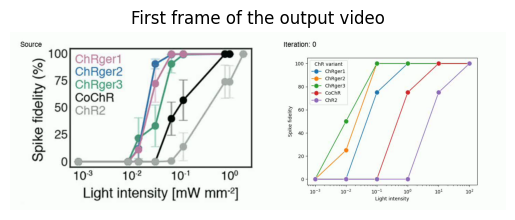

In [31]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")


/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_39940/1437840151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


[]

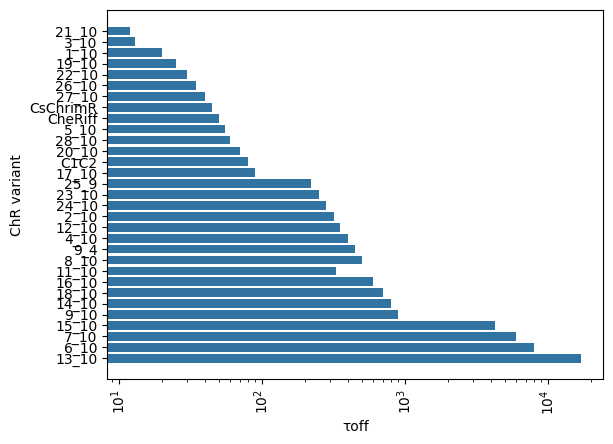

In [27]:
# panel_df_adjusted = panel_df.copy()
# panel_df_adjusted['τoff'] *= 1000

# horizontal bar plot
axes = sns.barplot(
    data=panel_df,
    x='τoff',
    y='ChR variant',
    orient='h',
)
# axes = sns.barplot(
#     data=panel_df,
#     x='ChR variant',
#     y='τoff',
# )
# rotate x-tick labels 90 deg
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.semilogx()



<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

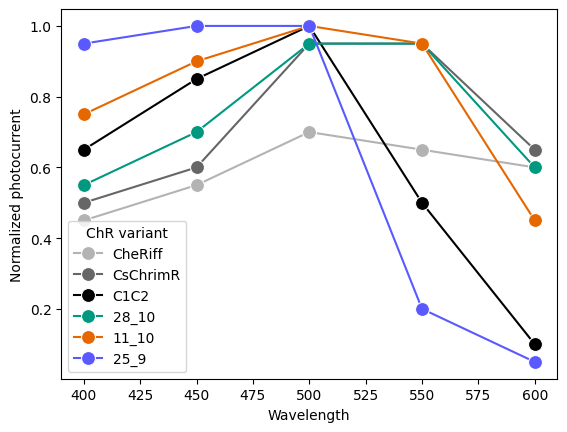

In [127]:


sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    palette=[[0.7, 0.7, 0.7], [0.4, 0.4, 0.4], [0, 0, 0], [0, .6 , .5], [0.9, 0.4, 0.0], [0.35, 0.35, 1.0]]
)
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import MetadataMode

In [42]:
for node in retrieverd_nodes[:-1]:
    try:
        display_source_node(node, source_length=100000)
    except:
        print(node)

**Node ID:** 7cf5ee59-0e97-445f-8884-f4e21f7bba21<br>**Similarity:** 0.40960259534169907<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)<br>

**Node ID:** 5cb68f1f-e64c-4502-9da2-c42717a765e2<br>**Similarity:** 0.4057491962557034<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.<br>

**Node ID:** d04f54e0-29ba-4046-92a6-7d2c6e9268f0<br>**Similarity:** 0.3793601396922902<br>**Text:** Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

Section a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_10 in purple, and 3_10 in red. The bottom row shows fluorescence images of ChR expression in HEK cells, with a 20 μm scale bar.

Section b displays measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n=4-8 cells, see Dataset 2). Four wavelengths are shown: 397 nm, 481 nm, 546 nm, and 640 nm. The y-axis shows photocurrent in pA, with different scales for each wavelength. Peak currents are represented by dark gray bars, while steady-state currents are in light gray. Error bars are included.

Section c shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm^2 (n=4-8 cells, see Dataset 2). Parent ChRs are highlighted in light gray. The x-axis shows τoff values on a logarithmic scale from 10^1 to 10^4 ms. Inset shows representative current traces with 1 ms light exposure for select ChRs revealing distinct profiles: ChR_21_10 (purple) turns off rapidly, ChR_3_10 (red) and ChR_25_9 (light blue) turn off more slowly, and ChR_15_10 (blue) exhibits little decrease in photocurrent 0.5 s after the light exposure. The time scale for these traces is 100 ms.

Section d shows normalized photocurrent as a function of wavelength for various ChR variants. The wavelengths range from 400 nm to 600 nm. Different colored lines represent different ChR variants, corresponding to the colors in panel a.

Section e displays peak photocurrent (left) and steady-state photocurrent (right) as a function of light intensity for various ChR variants. The x-axis shows light intensity from 10^-1 to 10^1 mW mm^-2 on a logarithmic scale. The y-axis shows photocurrent in pA, up to 2500 pA. Different colored lines represent different ChR variants, corresponding to the colors in panel a. Error bars are included.<br>**Image:**

**Node ID:** 22d9ee84-5d29-4f92-8527-e0ae97939355<br>**Similarity:** 0.36910398090655805<br>**Text:** Selection of designer ChRs using trained models<br>

**Node ID:** 5bbfd688-9a2b-439b-a86b-c786e9c193e7<br>**Similarity:** 0.35990217183769474<br>**Text:** Light delivery and imaging<br>

In [47]:
index_node = node.node

In [49]:
index_node.

'Light delivery and imaging'